In [56]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 12

In [58]:
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)


In [59]:
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state

In [60]:
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2

In [61]:
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state


In [62]:
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state

In [63]:
#ansatz state |ψ(θ)⟩
def ansatz(theta, n_qubits):
    state = initial_state(n_qubits)
    for i in range(n_qubits):
        state = apply_single_qubit_gate(state, RY(theta[i]), i, n_qubits)
    for i in range(n_qubits - 1):
        state = apply_cnot(state, i, i + 1, n_qubits)
    return state

In [64]:
#Hamiltonian H = Σ Z_i + Σ Z_i Z_{i+1}
def build_hamiltonian(n_qubits):
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)
    # Single Z terms
    for i in range(n_qubits):
        ops = [I] * n_qubits
        ops[i] = Z
        H += kron_n(*ops)
    # Pairwise Z_i Z_{i+1}
    for i in range(n_qubits - 1):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[i + 1] = Z
        H += kron_n(*ops)
    return H

In [65]:
#Expectation value ⟨ψ|H|ψ⟩
def expectation(theta, H, n_qubits):
    psi = ansatz(theta, n_qubits)
    return np.real(np.vdot(psi, H @ psi))


In [66]:
H = build_hamiltonian(n_qubits)
def cost(theta):
    return expectation(theta, H, n_qubits)

In [26]:
#Optimising using Nelder-Mead algorithm
def nelder_mead(f, x_start, step=0.5, tol=1e-6, max_iter=500):
    n = len(x_start)
    # Initialize simplex
    f_history = []
    simplex = [x_start]
    for i in range(n):
        x = np.array(x_start, dtype=float)
        x[i] += step
        simplex.append(x)
    simplex = np.array(simplex)
    #$print(simplex)
    for iteration in range(max_iter):
        # Sort simplex points by function value
        simplex = sorted(simplex, key=f)
        f_values = [f(x) for x in simplex]

        # Check convergence
        if np.std(f_values) < tol:
            break

        # Compute centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        xr = centroid + (centroid - simplex[-1])
        fr = f(xr)

        if f_values[0] <= fr < f_values[-2]:
            simplex[-1] = xr
        elif fr < f_values[0]:
            # Expansion
            xe = centroid + 2 * (xr - centroid)
            fe = f(xe)
            simplex[-1] = xe if fe < fr else xr
        else:
            # Contraction
            xc1 = simplex[-1] + 0.25 * (xr-simplex[-1] )   
            xc3 = simplex[-1] + 0.75 * (xr-simplex[-1] )
            fc1 = f(xc1)
            fc3 = f(xc3)
            xc = 0
            fc = 0
            if fc1 < fc3:
                xc,fc= xc1,fc1
            else:
                xc,fc = xc3,fc3
            if fc < f_values[-1]:
                simplex[-1] = xc1
            else:
                # Shrink
                for i in range(1, len(simplex)):
                    simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])
        f_history.append(f_values[0])
    best = min(simplex, key=f)
    return best, f(best), iteration + 1,f_history


x0 = np.random.uniform(0, 2 * np.pi, n_qubits)
solnmn, fval, iters,fhisto = nelder_mead(cost, x0)
print("[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", fval)
print("[Nelder-Mead] Optimal θ:", solnmn)
print("[Nelder-Mead] Iterations:", iters)
print(fhisto)

KeyboardInterrupt: 

In [27]:
plt.plot(fhisto)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Nelder mead Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

NameError: name 'fhisto' is not defined

In [57]:
# Optimising using SPSA algorithm
a = 0.5
c = 0.1
A = 10
alpha = 0.602
gamma = 0.101
f_history = []

# Initial point
theta = np.random.uniform(0, 2 * np.pi, n_qubits)
max_iterations = 1000
tolerance = 1e-6
np.random.seed(42)

for k in range(max_iterations):
    ak = a / (A + k + 1)**alpha
    ck = c / (k + 1)**gamma
    delta = np.random.choice([-1, 1], size=n_qubits)  #perturbation vector Δ_k from Bernoulli(±1)
    theta_plus = theta + ck * delta
    theta_minus = theta - ck * delta
    y_plus = cost(theta_plus)
    y_minus = cost(theta_minus)
    g_hat = (y_plus - y_minus) / (2 * ck) * (1.0 / delta)
    theta = theta - ak * g_hat
    f_val = cost(theta)
    f_history.append(f_val)
    print (k)
    if k > 0 and abs(f_history[-1] - f_history[-2]) < tolerance:
        #print(f"[SPSA] Stopped early at iteration {k+1}: Δf = {abs(f_history[-1] - f_history[-2]):.2e} < {tolerance}")
        break
solspsa=theta
print("[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", f_val)
print("[SPSA] Optimal θ:", theta)
print("[SPSA] Iterations:", len(f_history))
print(f_history)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4096 is different from 1024)

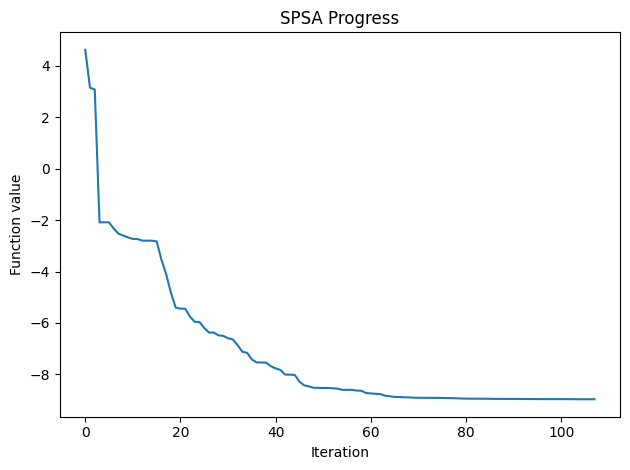

In [47]:
plt.plot(f_history)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('SPSA Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [67]:
#Optimising using L-BFGS algorithm
def lbfgs(f, grad_f, x0, m=50, tol=1e-6, max_iter=1000):
    x = x0.copy()
    k = 0  # iteration counter
    s_list = []   
    y_list = []   
    rho_list = [] 
    g = grad_f(x)
    f_histry = []
    BOUND = 0  # number of updates used
    while np.linalg.norm(g) > tol and k < max_iter:
        q = g.copy()
        alpha = []
        if k < m:
            INCR = 0
            BOUND = k
        else:
            INCR = k - m
            BOUND = m
        for i in range(BOUND - 1, -1, -1):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            alpha_i = rho * np.dot(s, q)
            alpha.append(alpha_i)
            q = q - alpha_i * y

        alpha = alpha[::-1]  # to use in forward loop later

        if k > 0:
            y_last = y_list[-1]
            s_last = s_list[-1]
            gamma = np.dot(s_last, y_last) / np.dot(y_last, y_last)
        else:
            gamma = 1.0
        r = gamma * q
        for i in range(0, BOUND):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            beta = rho * np.dot(y, r)
            r = r + s * (alpha[i] - beta)

        #search direction and backtracking line search
        p = -r
        t = 1.0
        while f(x + t * p) > f(x) + 1e-4 * t * np.dot(g, p):
            t *= 0.5
            if t < 1e-10:
                break
        #position and gradient update
        x_new = x + t * p
        g_new = grad_f(x_new)
        s_k = x_new - x
        y_k = g_new - g

        #store s_k, y_k, and ρ_k if curvature condition satisfied
        if np.dot(s_k, y_k) > 1e-10:
            s_list.append(s_k)
            y_list.append(y_k)
            rho_list.append(1.0 / np.dot(y_k, s_k))

            #maintaining memory size
            if len(s_list) > m:
                s_list.pop(0)
                y_list.pop(0)
                rho_list.pop(0)

        x = x_new
        g = g_new
        k += 1
        f_histry.append(f(x))
        #print(f"Iter {k:2d} | f(x) = {f(x):.6f} | ||grad|| = {np.linalg.norm(g):.2e}") 
    return x, f(x), k , f_histry


In [68]:
#writing a function grad that calculates gradient numerically 
def grad_numerical(func, v, h=1e-3):
    grad = np.zeros_like(v)
    for i in range(len(v)):
        v_plus = np.copy(v)
        v_minus = np.copy(v)
        v_plus[i] += h
        v_minus[i] -= h
        grad[i] = (func(v_plus) - func(v_minus)) / (2 * h)
    return grad

In [69]:
#seting initial points randomly
x0 = np.random.uniform(0, 2 * np.pi, n_qubits)  # Random initial point
print("Initial point:", x0)
sollbgfs,fvalue,niter ,fhist= lbfgs(cost , lambda x: grad_numerical(cost, x), x0)
print("[L-BFGS] Optimal θ: ",sollbgfs) 
print("[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: ",fvalue)
print("[L-BFGS] Iterations:", niter)
print(fhist)

Initial point: [0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333
 5.23039137 1.33416598 1.14243996 1.15236452 1.91161039 3.2971419 ]
[L-BFGS] Optimal θ:  [3.1415925  3.14159252 3.14159265 5.67831009 3.1415925  3.14159257
 3.14159259 3.14159242 3.1415927  3.14159251 3.14159276 3.14159271]
[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:  -10.999999999999865
[L-BFGS] Iterations: 17
[-2.329035427489855, -6.4269797692689865, -7.9322881674073855, -8.67315317830475, -9.49977192693157, -10.164664109856984, -10.747523205831053, -10.961052901425964, -10.995829065949122, -10.999809002951745, -10.999996320161417, -10.99999995687812, -10.999999999437804, -10.999999999946898, -10.999999999996861, -10.999999999999453, -10.999999999999865]


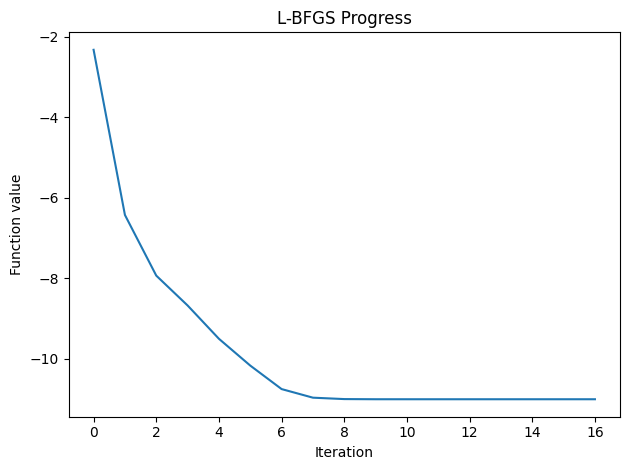

In [70]:
plt.plot(fhist)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('L-BFGS Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [51]:
#Optimizing using Adam algorithm
def adam_optimize(func, grad, theta_init, alpha=0.1, beta1=0.9, beta2=0.999,epsilon=1e-8, max_iters=100, tolerance=1e-6):
    theta = theta_init.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)

    thetas = [theta.copy()]
    losses = [func(theta)]
    f_history = []
    for t in range(1, max_iters + 1):
        g = grad_numerical(func, theta)

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        f_val = func(theta)
        thetas.append(theta.copy())
        losses.append(f_val)
        f_history.append(f_val)
        # Early stopping based on function change
        if abs(losses[-1] - losses[-2]) < tolerance:
                #print(f"[Adam] Early stopping at iteration {t}: Δf = {abs(losses[-1] - losses[-2]):.2e} < {tolerance}")
                break

    return theta, losses, thetas, f_history


In [54]:

theta_init = np.random.uniform(0, 2 * np.pi, n_qubits)  # Initial guess for θ
soladam, loss_history, theta_path,fhistory = adam_optimize(cost, lambda x: grad_numerical(cost, x), theta_init)
print(f"[Adam] Optimal θ: {soladam}")
print(f"[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: {loss_history[-1]:.6f}")
print(f"[Adam] Iterations: {len(loss_history)}")
print(fhistory)

KeyboardInterrupt: 

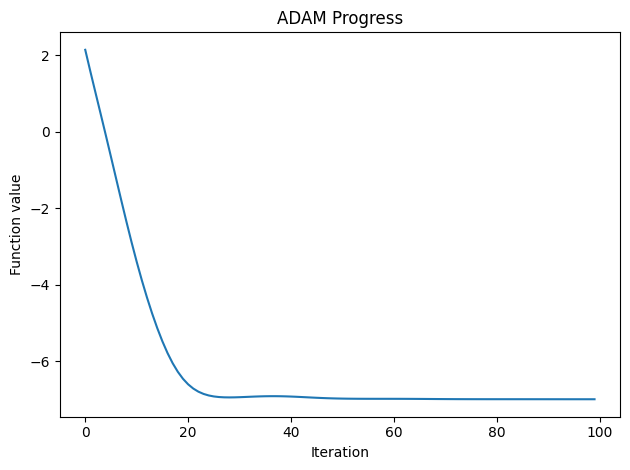

In [228]:
plt.plot(fhistory)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('ADAM Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [202]:
def bfgs(f, grad_f, x0, tol=1e-6, max_iter=100):
    x = x0.astype(float)
    trajectory = [x.copy()]
    n = len(x)
    H = np.eye(n)
    epsilon = 1e-10
    damping = 1e-4

    history = [f(x)] 
    direction_norms = []  # <-- new

    for i in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            print(f"Converged in {i} iterations.")
            break

        p = -H @ grad
        direction_norms.append(np.linalg.norm(p))  # <-- store norm of direction

        # Backtracking line search
        alpha = 1.0
        c, rho = 1e-4, 0.5
        while f(x + alpha * p) > f(x) + c * alpha * grad @ p:
            alpha *= rho

        x_new = x + alpha * p
        s = x_new - x
        y = grad_f(x_new) - grad

        ys = y @ s
        if ys < epsilon:
            y_damped = y + damping * s
            ys_damped = y_damped @ s
            if ys_damped < epsilon:
                #print(f"Skipping update at iter {i}: even damped y.T@s is too small.")
                x = x_new
                history.append(f(x))
                continue
            else:
                y = y_damped
                ys = ys_damped

        rho = 1.0 / ys
        I = np.eye(n)
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)

        x = x_new
        trajectory.append(x.copy())
        history.append(f(x))

    print("Final point:", x)
    print("Final function value:", f(x))
    return x, history  


In [203]:
x0 = np.random.uniform(0, 2 * np.pi, n_qubits)
solbfgs, history = bfgs(cost, lambda x: grad_numerical(cost, x), x0)


Converged in 14 iterations.
Final point: [3.14159274 2.17339377 3.14159265 3.14159261 3.14159259 3.14159252
 3.14159267 3.14159265]
Final function value: -6.999999999999989


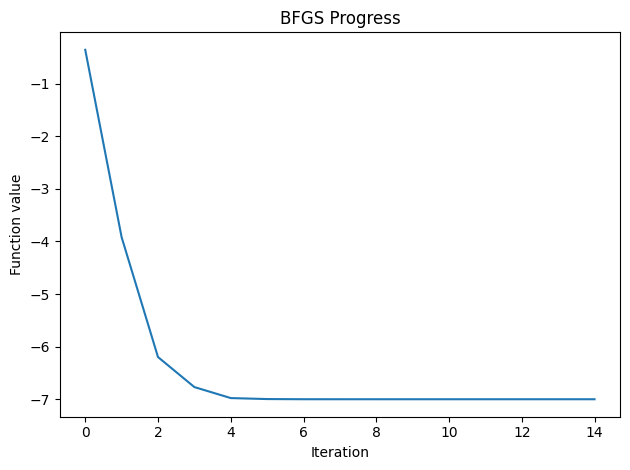

In [205]:
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('BFGS Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

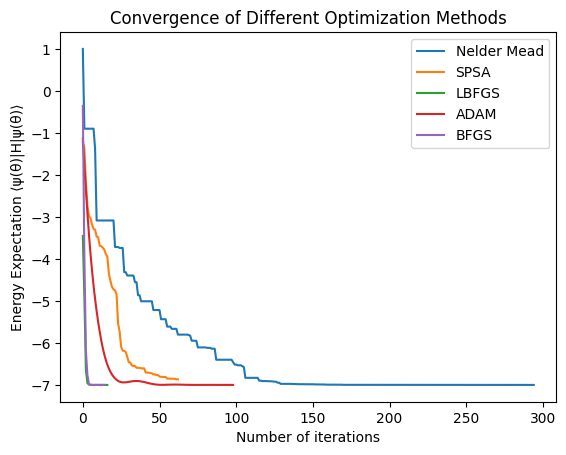

In [215]:
import matplotlib.pyplot as plt

y1 = fhisto
y2 = f_history
y3 = fhist
y4 = fhistory
y5 = history

# Generate corresponding x-values automatically
x1 = list(range(len(y1)))
x2 = list(range(len(y2)))
x3 = list(range(len(y3)))
x4 = list(range(len(y4)))
x5 = list(range(len(y5)))

# Plot each with its own x
plt.plot(x1, y1, label='Nelder Mead')
plt.plot(x2, y2, label='SPSA')
plt.plot(x3, y3, label='LBFGS')
plt.plot(x4, y4, label='ADAM')
plt.plot(x5, y5, label='BFGS')

plt.xlabel('Number of iterations')
plt.ylabel('Energy Expectation ⟨ψ(θ)|H|ψ(θ)⟩')
plt.title('Convergence of Different Optimization Methods')
plt.legend()
plt.grid(False)
plt.show()


In [146]:
#below this are inbuilt optimizers

In [28]:
from scipy.optimize import minimize
theta0 = np.random.uniform(0, 3*np.pi, size=n_qubits)
print("Initial θ:", theta0)
# Optimize using classical optimizer (e.g., BFGS)
result = minimize(cost, theta0, method='BFGS', options={'disp': True})

# Final optimized value
print("\n[BFGS] Optimal energy ⟨ψ(θ)|H|ψ(θ)⟩:", result.fun)
print("[BFGS] Optimal θ:", result.x)


Initial θ: [2.64621717 0.22917258 6.08343307 1.66922883 8.86361334 8.99056503
 8.62239374 3.48866356]
Optimization terminated successfully.
         Current function value: -7.000000
         Iterations: 15
         Function evaluations: 207
         Gradient evaluations: 23

[BFGS] Optimal energy ⟨ψ(θ)|H|ψ(θ)⟩: -6.999999999995601
[BFGS] Optimal θ: [ 3.14159302 -0.31087204  3.14159055  3.14159338  9.42477893  9.42477723
  9.42477874  3.14159316]


In [29]:
theta0 = np.random.uniform(0, 3*np.pi, size=n_qubits)
# Run Nelder-Mead
result_nm = minimize(cost, theta0, method='Nelder-Mead', options={'disp': True})

print("[Nelder-Mead] Optimal value:", result_nm.fun)
print("[Nelder-Mead] Optimal θ:", result_nm.x)


Optimization terminated successfully.
         Current function value: -7.000000
         Iterations: 266
         Function evaluations: 421
[Nelder-Mead] Optimal value: -6.999999996916152
[Nelder-Mead] Optimal θ: [0.14177858 9.42479913 3.14157264 9.42476276 9.42474269 9.42474912
 3.14155386 3.14159503]


In [ ]:
#Projective measurements

In [ ]:
def sample_bitstrings(statevector, n_samples):
    probs = np.abs(statevector) ** 2
    assert np.isclose(np.sum(probs), 1.0), "Probabilities must sum to 1"
    outcomes = np.random.choice(len(probs), size=n_samples, p=probs) 
    bitstrings = [format(i, f'0{n_qubits}b') for i in outcomes]
    return bitstrings


In [ ]:
theta = sollbgfs  # example parameters
state = ansatz(theta, 8)
bitstrings = sample_bitstrings(state , 10000)
print(bitstrings)
print("Sampled bitstrings:", len(bitstrings))

['01010101', '01010101', '01010101', '01010101', '01010101', '01010101', '10101010', '10101010', '10101010', '01010101', '10101010', '10101010', '01010101', '01010101', '01010101', '01010101', '01010101', '01010101', '10101010', '01010101', '01010101', '10101010', '01010101', '10101010', '01010101', '10101010', '01010101', '01010101', '01010101', '10100101', '10101010', '01010101', '10101010', '01010101', '01010101', '10101010', '01010101', '01010101', '10101010', '10101010', '10101010', '10101010', '01010101', '10101010', '01010101', '10101010', '01010101', '01010101', '01010101', '01010101', '01010101', '10101010', '10101010', '01010101', '10101010', '01010101', '01010101', '01010101', '10101010', '01011010', '01010101', '01010101', '01010101', '01010101', '01010101', '01010101', '01010101', '10101010', '01010101', '01010101', '01010101', '10101010', '10101010', '10101010', '01010101', '10101010', '01010101', '01010101', '01010101', '01010101', '10101010', '10101010', '01010101', '01

In [155]:
def generate_hamiltonian(n_qubits=8):
    hamiltonian = []

    # Single-qubit terms:
    for i in range(n_qubits):
        hamiltonian.append((1.0, [i]))

    # Two-qubit terms
    for i in range(n_qubits - 1):
        hamiltonian.append((1.0, [i, i + 1]))
    return hamiltonian

hamiltonian_terms = generate_hamiltonian(8)

In [220]:
def estimate_expectation(bitstrings, hamiltonian_terms):
    total = 0
    for bitstring in bitstrings:
        val = 0
        for coeff, qubits in hamiltonian_terms:
            product = 1
            for q in qubits:
                product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
            val += coeff * product
        total += val
    return total / len(bitstrings)

In [230]:
expect_val = estimate_expectation(bitstrings, hamiltonian_terms)
print("Estimated ⟨H⟩ =", expect_val)

Estimated ⟨H⟩ = -6.972


In [175]:
def bitstring_energy(bitstring, hamiltonian_terms):
    val = 0
    for coeff, qubits in hamiltonian_terms:
        product = 1
        for q in qubits:
            product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
        val += coeff * product
    return val


In [231]:
from collections import Counter
bitstring_counts = Counter(bitstrings)
bitstring_data = []
for bitstring, count in bitstring_counts.items():
    energy = bitstring_energy(bitstring, hamiltonian_terms)
    bitstring_data.append((bitstring, count, energy))
print(bitstring_data)


[('01010101', 6871, -7.0), ('10101010', 2996, -7.0), ('10100101', 25, -5.0), ('01011010', 58, -5.0), ('10101101', 1, -7.0), ('01101010', 18, -5.0), ('10010101', 6, -5.0), ('01001010', 6, -3.0), ('01010110', 6, -5.0), ('01010100', 4, -3.0), ('10101001', 3, -5.0), ('10110101', 3, -7.0), ('10101011', 1, -7.0), ('01010010', 2, -3.0)]


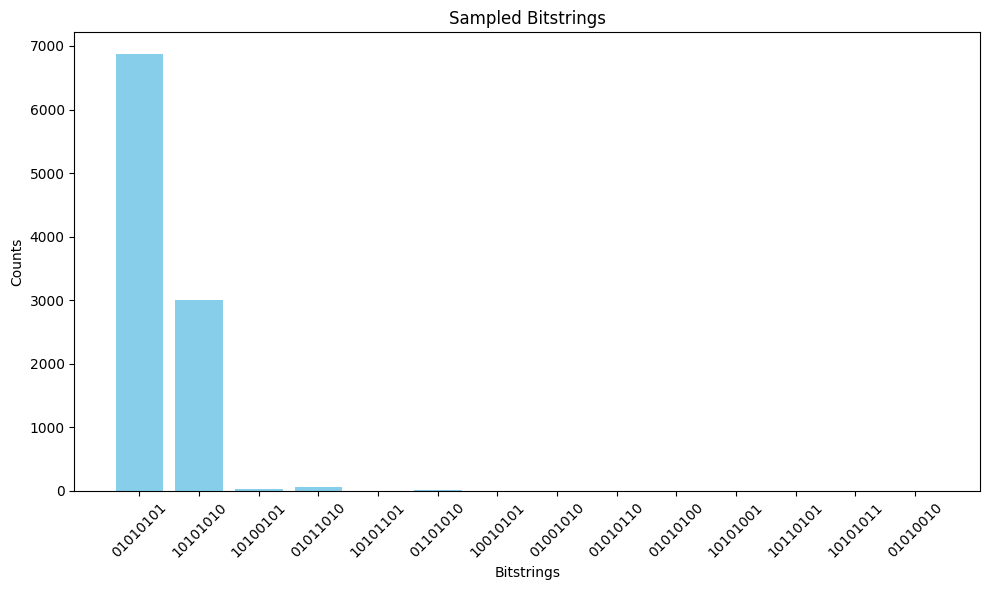

In [232]:
bitstrings_unique = list(bitstring_counts.keys())
frequencies = list(bitstring_counts.values())
plt.figure(figsize=(10,6))
plt.bar(bitstrings_unique, frequencies, color='skyblue')
plt.xlabel('Bitstrings')
plt.ylabel('Counts')
plt.title('Sampled Bitstrings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
